In [1]:
import os
import datetime as dt

import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from scipy.integrate import solve_ivp

from coropy.compartmental_models import SEIRDModel
import plotting

In [2]:
plotting.configure()
b = plotting.default_colors('blue')
o = plotting.default_colors('orange')
g = plotting.default_colors('green')
r = plotting.default_colors('red')

In [34]:
# all data
DATA_DIR = 'data'
FILE_NAMES = ['initial_timeseries_SEIRD.csv',
              '2nd_wave_timeseries_SEIRD.csv']
FILE_PATHS = [os.path.join(os.pardir, DATA_DIR, FILE_NAMES[0]),
              os.path.join(os.pardir, DATA_DIR, FILE_NAMES[1])]
df_1 = pd.read_csv(FILE_PATHS[0])
df_2 = pd.read_csv(FILE_PATHS[1])
df = pd.concat([df_1, df_2[1:-1]], sort=False)

# derived data
cum_positives = np.cumsum(df.confirmed_positives.values)
cum_recovered = df.estimate_recovered.values
cum_deceased = np.cumsum(df.confirmed_deceased.values)
active = cum_positives - cum_recovered - cum_deceased

eff_dates=[dt.datetime(2020, 2, 25), dt.datetime(2020, 6, 15), dt.datetime(2020, 8, 8)]

In [35]:
# system of odes
def SEIRD_ode(t, y, beta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R + D
    return [
        -beta*S*I/N, #- delta*S*E, 
        beta*S*I/N - alpha*E, #+ delta*S*E, 
        alpha*E - gamma*I - mu*I, 
        gamma*I,
        mu*I,
    ]

In [36]:
eff_population_scaler = 1
first_wave_eff_population = 2200

S0 = first_wave_eff_population * eff_population_scaler
E0 = 5 * cum_positives[0]
I0 = cum_positives[0]
R0 = cum_recovered[0]
D0 = cum_deceased[0]
IC = (S0, E0, I0, R0, D0)

S_tot, E_tot, I_tot, R_tot, D_tot = [], [], [], [], []
opt_params = np.zeros((len(eff_dates), 4))

# past wave(s)
start_idx = 0
for param_idx, (start_date, end_date) in enumerate(zip(eff_dates[:-1], eff_dates[1:])):
    end_idx = start_idx+abs((end_date - start_date).days)
    model = SEIRDModel(ode_system=SEIRD_ode)
    _, _ = model.fit(cum_positives[start_idx:end_idx], cum_recovered[start_idx:end_idx], cum_deceased[start_idx:end_idx], IC, guess=[0.1, 0.1, 0.1,0.1])
    opt_params[param_idx, :] = model.get_params
    (S, E, I, R, D) = model.simulate()
    S_tot.extend(S.tolist())
    E_tot.extend(E.tolist())
    I_tot.extend(I.tolist())
    R_tot.extend(R.tolist())
    D_tot.extend(D.tolist())
    
    eff_population_scaler += 2
    S0 = S0 * eff_population_scaler
    IC = (S0, 3 * I[-1], I[-1], R[-1], D[-1])  # update initial conditions
    start_idx = end_idx  # update indexing

# current wave   
model = SEIRDModel(ode_system=SEIRD_ode)
_, _ = model.fit(cum_positives[start_idx:], cum_recovered[start_idx:], cum_deceased[start_idx:], IC, guess=[0.1, 0.1, 0.1, 0.1,])
opt_params[-1, :] = model.get_params
(S, E, I, R, D) = model.simulate()
S_tot.extend(S.tolist())
E_tot.extend(E.tolist())
I_tot.extend(I.tolist())
R_tot.extend(R.tolist())
D_tot.extend(D.tolist())

INFO:root:L-BFGS-B optimization started: 2020-10-13 14:21:50.319387
INFO:root:Elapsed time: 5.7906s
INFO:root:L-BFGS-B optimization started: 2020-10-13 14:21:56.122255
INFO:root:Elapsed time: 1.4281s
INFO:root:L-BFGS-B optimization started: 2020-10-13 14:21:57.556388
INFO:root:Elapsed time: 0.5829s


In [37]:
opt_params

array([[3.97701215e-01, 2.13125326e-01, 4.05908819e-02, 7.25607359e-04],
       [1.96176986e-01, 1.88146922e-01, 6.60460865e-02, 2.78168117e-03],
       [2.73512055e-01, 4.05712872e-02, 7.22723568e-02, 1.00000000e-05]])

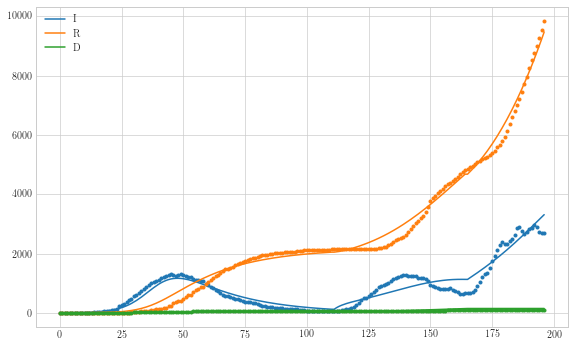

In [44]:
plt.plot(active, '.', c=b)
plt.plot(I_tot, c=b, label='I')
plt.plot(cum_recovered, '.', c=o)
plt.plot(R_tot, c=o, label='R')
plt.plot(cum_deceased, '.', c=g)
plt.plot(D_tot, c=g, label='D')
plt.legend()
plt.show()